# Abalone Introduction

"Abalone are marine snails which also commonly known as ear shells, sea ears, and muttonfish or muttonshells in Australia, ormer in the UK, perlemoen in South Africa, and paua in New Zealand. The flesh of abalones is widely considered to be a desirable food, and is consumed raw or cooked by a variety of cultures. The meat (foot muscle) of abalone is used for food, and the shells of abalone are used as decorative items and as a source of mother of pearl for jewelry, buttons, buckles, and inlay." - Wikipedia

<img max-width=480, width=480, src='https://crosscut.com/sites/default/files/styles/max_2000x2000/public/images/articles/pintoalolone_hero_0.jpg?itok=KXvtGAuQ' alt='abalone image'>

"The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age. The dataset provides Rings data which is numerical value where the age of the abalone can be apporximated within 1.5 years of the Rings data. Further information, such as weather patterns and location (hence food availability) may be required to solve the problem." - http://archive.ics.uci.edu/ml/datasets/Abalone

In [122]:
import time
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

# from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 1. Import Dataset

In [76]:
dataRaw = []
DataFile = open("dataset/abalone.data", "r")

while True:
    the_line = DataFile.readline()
    if len(the_line) == 0:
        break
  
    readData = the_line.split(",")
    for pos in range(len(readData)):
        if "\n" in readData[pos]:
            readData[pos] = readData[pos].replace("\n","")
    dataRaw.append(readData)

DataFile.close()

colsName_abalone = ['sex', 'length', 'diameter', 'height', 
                    'whole_weight', 'shucked_weight', 'viscera_weight', 
                    'shell_weight', 'rings']

df = pd.DataFrame(
    data=dataRaw,
    columns=colsName_abalone
)

df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
1,M,0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,7
2,F,0.53,0.42,0.135,0.677,0.2565,0.1415,0.21,9
3,M,0.44,0.365,0.125,0.516,0.2155,0.114,0.155,10
4,I,0.33,0.255,0.08,0.205,0.0895,0.0395,0.055,7


In [77]:
df.isnull().sum()

sex               0
length            0
diameter          0
height            0
whole_weight      0
shucked_weight    0
viscera_weight    0
shell_weight      0
rings             0
dtype: int64

# 3. Visualisation

In [78]:
le = LabelEncoder()

num_df = df.copy()

# sex, F=0, I=1, M=2, 
num_df['sex'] = le.fit_transform(num_df['sex'])

num_df = num_df.apply(pd.to_numeric)
num_df.head()
num_df.corr().style.background_gradient(cmap='binary')

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
sex,1.000000,-0.036066,-0.038874,-0.042077,-0.021391,-0.001373,-0.032067,-0.034854,-0.034627
length,-0.036066,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
diameter,-0.038874,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
height,-0.042077,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
whole_weight,-0.021391,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
shucked_weight,-0.001373,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
viscera_weight,-0.032067,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
shell_weight,-0.034854,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
rings,-0.034627,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


Overall, female abalones are slightly larger than male abalones in every physical attribute

In [79]:
sex_comparison = num_df.groupby('sex').mean()
sex_comparison.index = ['Female', 'Infant', 'Male']
sex_comparison

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
Female,0.579093,0.454732,0.158011,1.046532,0.446188,0.230689,0.302010,11.129304
Infant,0.427746,0.326494,0.107996,0.431363,0.191035,0.092010,0.128182,7.890462
Male,0.561391,0.439287,0.151381,0.991459,0.432946,0.215545,0.281969,10.705497


# 4. Preprocessing

# 5. Modelling

In [116]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m, x_train, y_train, x_test, y_test):
    res =[rmse(m.predict(x_train), y_train),
          rmse(m.predict(x_test), y_test),
          m.score(x_train, y_train),
          m.score(x_test, y_test)]
    if hasattr(m,'oob_score_'):res.append(m.oob_score_)
    print(res)
    
def feature_importance(m, df_train):
    importance = m.feature_importances_
    importance = pd.DataFrame(importance,index=df_train.columns,columns=["Importance"])
    return importance.sort_values(by=['Importance'],ascending=False)

In [117]:
X = num_df.drop('rings', axis=1, inplace=False)
y = num_df['rings']
    
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=21
)

model = RandomForestRegressor()
model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_test, y_test)

[0.8089374305451351, 2.2656572712600203, 0.9352960543776101, 0.5538181728455496]


                Importance
shell_weight      0.496175
shucked_weight    0.165599
whole_weight      0.084324
viscera_weight    0.077061
height            0.055130
diameter          0.051713
length            0.048813
sex               0.021186


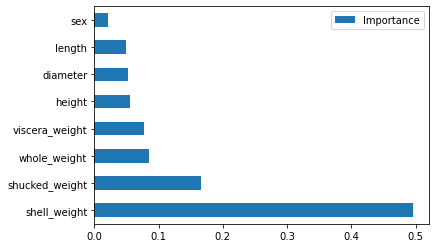

In [118]:
importance = feature_importance(model, X_train)
print(importance)
importance.plot(kind='barh')

In [120]:
to_keep = importance[importance['Importance'] > 0.05].index
X_fe = num_df[to_keep]
y_fe = num_df['rings']

X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, 
    y_fe, 
    test_size=0.2, 
    random_state=21
)

model_fe = RandomForestRegressor()
model_fe.fit(X_train_fe, y_train_fe)
print_score(model_fe, X_train_fe, y_train_fe, X_test_fe, y_test_fe)

[0.8083729376626901, 2.320345085496869, 0.9353863263108373, 0.5320185847047463]


In [123]:
n_estimators = [int(x) for x in np.arange(start = 10, stop = 2000, step = 10)]
max_features = [0.5,'auto', 'sqrt','log2']
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestRegressor()
search = RandomizedSearchCV(model, 
                            param_distributions=random_grid, 
                            n_iter=100, 
                            cv=3, 
                            verbose=2, 
                            random_state=42, 
                            n_jobs=-1
                           )

search.fit(X_train, y_train)
search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.9min finished


{'n_estimators': 1580,
 'min_samples_leaf': 4,
 'max_features': 0.5,
 'bootstrap': True}

In [124]:
X = num_df.drop('rings', axis=1, inplace=False)
y = num_df['rings']
    
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=21
)

model = RandomForestRegressor(n_estimators=1580, min_samples_leaf=4, max_features=0.5, bootstrap=True)
model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_test, y_test)

[1.4410778992744016, 2.2533521440163997, 0.7946589314354139, 0.5586515735862723]
